#### Setup (run before eval)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

nInst = 0
nt = 0
commRate = 0.0010
dlrPosLimit = 10000

In [2]:
def loadPrices(fn, stock=None):
    global nt, nInst
    df = pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    (nt, nInst) = df.shape
    if stock is not None:
        return (df[stock].values).T
    return (df.values).T

def calcPL(prcHist, getPosition, debug=False):
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    for t in range(500, 751):
        prcHistSoFar = prcHist[:, :t]
        newPosOrig = getPosition(prcHistSoFar)
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits)
        deltaPos = newPos - curPos
        dvolumes = curPrices * np.abs(deltaPos)
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume
        comm = dvolume * commRate
        cash -= curPrices.dot(deltaPos) + comm
        curPos = np.array(newPos)
        posValue = curPos.dot(curPrices)
        todayPL = cash + posValue - value
        todayPLL.append(todayPL)
        value = cash + posValue
        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume

        if debug:
            print(f"Day {t} value: {value:.2f} todayPL: ${todayPL:.2f} $-traded: {totDVolume:.0f} return: {ret:.5f}")

    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd

    return pll, plmu, ret, plstd, annSharpe, totDVolume

def calcPLSingle(prcHist, getPosition, window, threshold, take_profit, stop_loss, debug=False):
    cash = 0
    curPos = 0
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    for t in range(500, 751):
        prcHistSoFar = prcHist[:t]
        newPosOrig = getPosition(prcHistSoFar, window, threshold, take_profit, stop_loss)
        curPrices = prcHistSoFar[-1]
        posLimits = int(dlrPosLimit / curPrices)
        newPos = np.clip(newPosOrig, -posLimits, posLimits)[0]
        deltaPos = newPos - curPos
        dvolumes = curPrices * np.abs(deltaPos)
        dvolume = dvolumes
        totDVolume += dvolume
        comm = dvolume * commRate
        cash -= (curPrices * deltaPos) + comm
        curPos = newPos
        posValue = curPos * curPrices
        todayPL = cash + posValue - value
        todayPLL.append(todayPL)
        value = cash + posValue
        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume

        if debug:
            print(f"Day {t} value: {value:.2f} todayPL: ${todayPL:.2f} $-traded: {totDVolume:.0f} return: {ret:.5f}")

    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd

    return pll, plmu, ret, plstd, annSharpe, totDVolume

#### Strategy

Change the file being imported to run your strategy, e.g.:
```python
from sample import getMyPosition as getPosition
```
to
```python
from clustering import getMyPosition as getPosition
```

Loaded 50 instruments for 750 days
=====
mean(PL): 3.6
return: 0.00138
StdDev(PL): 103.24
annSharpe(PL): 0.55 
totDvolume: 655339 
Score: -6.71


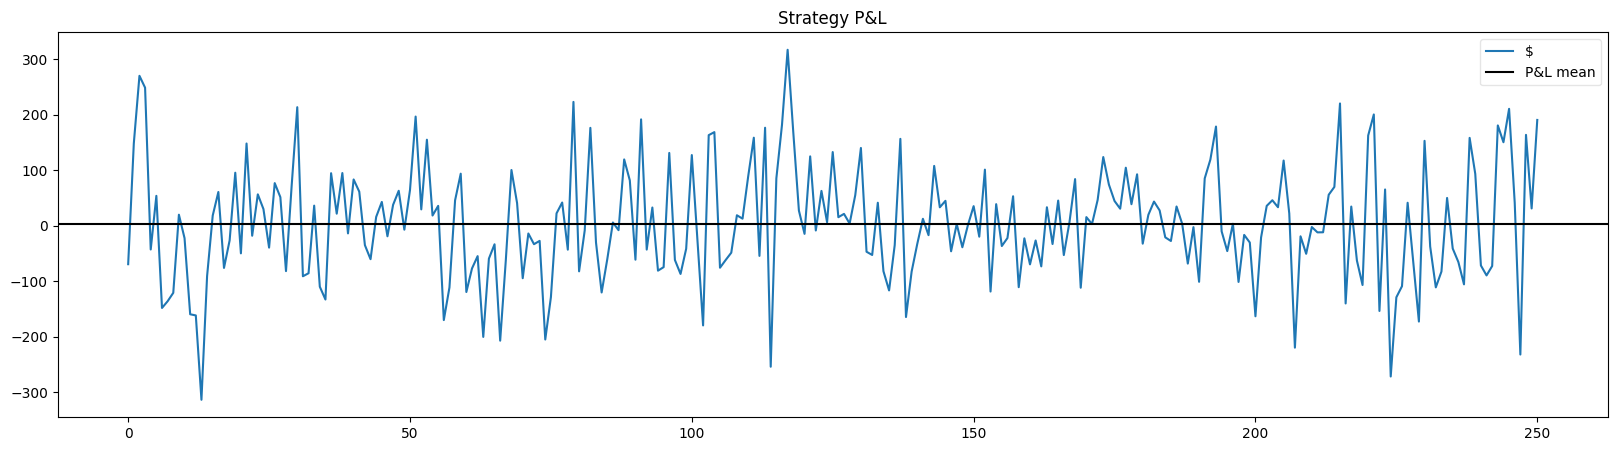

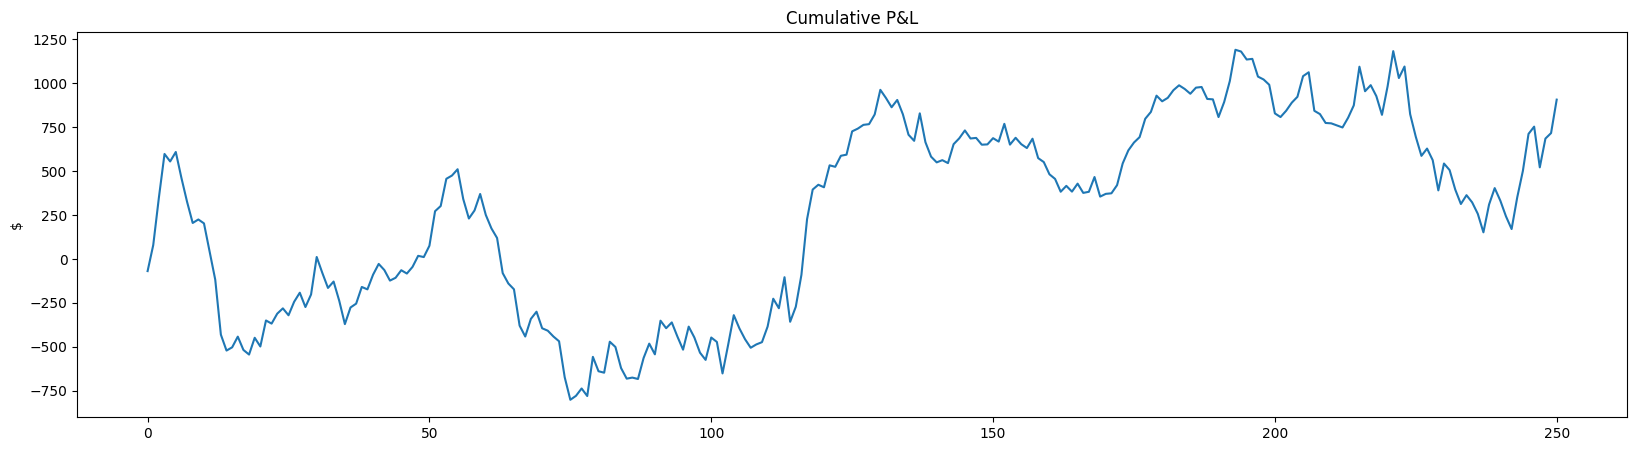

In [28]:
%reload_ext autoreload
%autoreload 2

### Change sample to your filename ###
from hurst_exponent import getMyPosition as getPosition

# !Do not edit below! #
pricesFile = "./prices.txt"
prcAll = loadPrices(pricesFile)
print("Loaded %d instruments for %d days" % (nInst, nt))

# Print stats
pll, meanpl, ret, plstd, sharpe, dvol = calcPL(prcAll, getPosition, debug=False)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

# Plot pll
fig = plt.figure(figsize=(20,5))
plt.plot(pll, label='$')
plt.axhline(meanpl, color='black', label='P&L mean')
plt.title('Strategy P&L')
plt.legend(fancybox=True, framealpha=0.5)
plt.show()
plt.close(fig)

# Plot cumulative pll
fig = plt.figure(figsize=(20,5))
plt.plot(np.cumsum(pll))
plt.ylabel('$')
plt.title('Cumulative P&L')
plt.show()
plt.close(fig)

In [8]:
# Change sample to your filename
from hurst_exponent import getMyPosition as getPosition

# !Do not edit below! #
pricesFile = "./prices.txt"
prcAll = loadPrices(pricesFile, 0)

means = np.zeros((4, 8))
stds = np.zeros((4, 8))
scores = np.zeros((4, 8))

for i, window in enumerate(range(100, 300, 50)):
    for j, threshold in enumerate(range(10, 50, 5)):
        threshold /= 100

        # Print stats
        pll, meanpl, ret, plstd, sharpe, dvol = calcPLSingle(prcAll, getPosition, -window, threshold, 0.1, 0.05)
        score = meanpl - 0.1*plstd
        # print("=====")
        # print("mean(PL): %.1lf" % meanpl)
        # print("return: %.5lf" % ret)
        # print("StdDev(PL): %.2lf" % plstd)
        # print("annSharpe(PL): %.2lf " % sharpe)
        # print("totDvolume: %.0lf " % dvol)
        # print("Score: %.2lf" % score)

        means[i][j] = meanpl
        stds[i][j] = plstd
        scores[i][j] = score

        # Plot pll
        fig = plt.figure(figsize=(20,5))
        plt.plot(pll, label='$')
        plt.axhline(meanpl, color='black', label='P&L mean')
        plt.title('Strategy P&L')
        plt.legend(fancybox=True, framealpha=0.5)
        plt.savefig(f"pll/stock{0}-pll-{window}-{threshold}.png")
        plt.close(fig)

        # Plot cumulative pll
        fig = plt.figure(figsize=(20,5))
        plt.plot(np.cumsum(pll))
        plt.ylabel('$')
        plt.title('Cumulative P&L')
        plt.savefig(f"pll/stock{0}-cum-{window}-{threshold}.png")
        plt.close(fig)

print(means)
print(stds)
print(scores)

[[ 0.70241833  1.4563506   1.30112749  1.48006375  1.68321514  2.48321116
   2.375749    2.28022709]
 [ 0.78738645  0.72799602  1.15784462  1.15784462  1.21754582  1.28918725
   1.3966494   2.28022709]
 [ 0.          0.22650598  0.477251    0.77575697  1.09814343  1.53993227
   1.96978088  3.13356574]
 [ 0.         -0.11976096  0.35784861  0.477251    0.6324741   1.24142629
   1.92702789  2.41784462]]
[[ 7.20151976 14.1032877  14.23098434 13.695701   14.54039635 15.37486994
  15.48587635 16.89696444]
 [11.12888877 11.98865466 12.36479702 12.63728429 13.68490691 13.76980536
  14.30240172 16.89696444]
 [ 0.         10.47421917 11.03130898 11.94671765 13.60302935 14.46728282
  14.82957138 19.18577974]
 [ 0.          1.71094856  6.73368485 11.03130898 11.54933125 12.47942492
  16.2487866  18.12043057]]
[[-0.01773365  0.04602183 -0.12197094  0.11049365  0.2291755   0.94572416
   0.82716137  0.59053065]
 [-0.32550242 -0.47086945 -0.07863508 -0.10588381 -0.15094487 -0.08779328
  -0.03359077  

In [12]:
scores.max()

1.2149877627248937